# **Visual Archetype Analysis of Geodemographic Clusters: Using Vision Language Models (VLMs) to Characterise Indian Districts**


**Author:** Ujjwal Kumar Swain  
**Stack:** Google Earth Engine (GEE); Anthropic Claude Vision API; Python  


**Project Overview**

This project investigates whether **Vision Language Models (VLMs)** can extract meaningful visual characteristics from **satellite imagery** that align with socio-demographic profiles derived from survey data (NFHS-5).

> **Can a Vision Language Model "see" demographic quality directly from satellite imagery?**

By feeding Sentinel-2 true-colour composites to Anthropic's Claude Vision API, we extract structured visual features, i.e., urban density, vegetation cover, road network complexity, informal settlement patterns and test whether these signals align with ground-truth NFHS-5 indicators. The result is a novel multimodal pipeline that bridges remote sensing, large language models, and demographic intelligence for evidence-based policymaking.



**Research Questions**

1. **Visual Discrimination**- Can VLMs detect visual signatures that meaningfully differentiate geodemographic clusters derived from survey data?
2. **Demographic Alignment**- Do satellite-derived visual feature scores correlate with NFHS-5 ground-truth indicators (literacy, stunting, institutional births)?
3. **Narrative Generation**- Can LLMs synthesise satellite observations into coherent visual archetype narratives that complement numeric profiling?
4. **Bias & Limitations**- What systematic biases emerge when deploying VLMs for geodemographic characterisation at district scale in India?



**Objectives**

- Select representative districts from 4 k-means geodemographic clusters (3 per cluster = 12 total)
- Retrieve cloud-free Sentinel-2 imagery via Google Earth Engine for each district
- Use Claude Vision API to extract 10 quantitative visual features per district
- Measure Pearson correlation between VLM scores and NFHS-5 demographic indicators
- Generate cluster-level visual archetype narratives combining image evidence and demographic context
- Document biases, limitations, and reproducibility considerations
- Export a standalone HTML/CSS visualization report and a downloadable results archive

**Pipeline**
```
4 Geodemographic Clusters (from NFHS-5 k-means)
        ↓
Representative District Selection (3 per cluster = 12 districts)
        ↓
Sentinel-2 Satellite Imagery (Google Earth Engine)
        ↓
Claude Vision API Analysis (structured JSON extraction)
        ↓
Visual Feature Comparison across Clusters
        ↓
Alignment Analysis: Do VLM observations match NFHS-5 indicators?
        ↓
Visual Archetype Narratives per Cluster
```


# **01. Install Dependencies**

Before we begin the analysis, we need to install the libraries that power this pipeline.
Each library plays a specific role: `earthengine-api` and `geemap` connect us to Google's planetary-scale geospatial infrastructure;
`anthropic` gives us access to Claude's vision capabilities; and the visualization stack (`plotly`, `folium`, `matplotlib`, `seaborn`)
lets us render our findings in an interactive and accessible way.

In [24]:
import subprocess, sys

packages = [
    'earthengine-api', 'geemap', 'anthropic',
    'pandas', 'numpy', 'matplotlib', 'seaborn',
    'plotly', 'kaleido==0.2.1', 'folium',
    'Pillow', 'requests', 'ipywidgets'
]

for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

print('All dependencies installed successfully')


All dependencies installed successfully


# **02. Import Libraries & Configure Workspace**

In [25]:
import ee
import geemap
import anthropic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import folium
from PIL import Image
import requests
import base64
import json
import os
import time
import zipfile
from pathlib import Path
from datetime import datetime
from IPython.display import display, HTML, FileLink
import warnings
warnings.filterwarnings('ignore')


# ─── Configuration ────────────────────────────────────────────────
GEE_PROJECT = 'ee-ujjwalkumarswainiirs1'


try:
    from google.colab import userdata
    ANTHROPIC_KEY = userdata.get('ANTHROPIC_API_KEY')
    print('Anthropic API key loaded from Colab Secrets')
except Exception:
    # Fallback: environment variable or manual entry
    ANTHROPIC_KEY = os.environ.get('ANTHROPIC_API_KEY', 'your-api-key-here')
    print('Colab Secrets not available — using environment variable')

IMAGE_DIR  = Path('images')
OUTPUT_DIR = Path('outputs')
IMAGE_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

START_DATE  = '2023-01-01'
END_DATE    = '2023-12-31'
CLOUD_PCT   = 15
BUFFER_KM   = 10
IMAGE_DIM   = 512

print(f'Libraries loaded | {datetime.now().strftime("%Y-%m-%d %H:%M")}')
print(f'Images → {IMAGE_DIR.resolve()}')
print(f'Outputs → {OUTPUT_DIR.resolve()}')


Anthropic API key loaded from Colab Secrets
Libraries loaded | 2026-02-26 05:22
Images → /content/images
Outputs → /content/outputs


# **03. District Selection & Cluster Definitions**

One of the most critical methodological decisions in this study is *which districts to analyse*.
With 694 clustered districts, we cannot feasibly run satellite image analysis on all of them.
Instead, we select **3 representative districts per cluster**- those closest to each cluster's centroid in the NFHS-5 feature space.
This ensures our sample reflects the 'typical' district in each group, not outliers.

The 4 clusters emerge from k-means clustering on three NFHS-5 indicators:
- **Women's Literacy %**- proxy for human capital and gender equity
- **Child Stunting %**- proxy for long-term nutritional deprivation
- **Institutional Births %**-  proxy for healthcare access and maternal health infrastructure

The cluster gradient runs from **Cluster 0 (high deprivation)** concentrated in eastern India to **Cluster 3 (better outcomes)** dominant in the south and west, a pattern that mirrors India's north-south development divide.

In [26]:
CLUSTER_COLORS = {0:'#1A237E', 1:'#1976D2', 2:'#26A69A', 3:'#66BB6A'}
CLUSTER_LABELS = {0:'High Deprivation', 1:'Moderate Deprivation', 2:'Transitioning', 3:'Better Developed'}

DISTRICTS = {
    0: [
        {'name':'Pakur',    'state':'Jharkhand',      'lat':24.64,'lon':87.84,'note':'Remote tribal district; high stunting, very low literacy'},
        {'name':'Purnea',   'state':'Bihar',           'lat':25.78,'lon':87.47,'note':'Dense agrarian plains; low institutional delivery'},
        {'name':'Nuapada',  'state':'Odisha',          'lat':20.77,'lon':82.53,'note':'Forest-fringe tribal belt; extreme deprivation indicators'},
    ],
    1: [
        {'name':'Sheohar',  'state':'Bihar',           'lat':26.52,'lon':85.30,'note':'Smallest Bihar district; flood-prone, high deprivation'},
        {'name':'Barmer',   'state':'Rajasthan',       'lat':25.75,'lon':71.39,'note':'Thar desert; sparse vegetation, low female literacy'},
        {'name':'Sitapur',  'state':'Uttar Pradesh',   'lat':27.57,'lon':80.68,'note':'Gangetic plains; mixed agricultural landscape'},
    ],
    2: [
        {'name':'Nashik',   'state':'Maharashtra',     'lat':19.99,'lon':73.79,'note':'Semi-urban; wine country, mixed demographic profile'},
        {'name':'Bhopal',   'state':'Madhya Pradesh',  'lat':23.26,'lon':77.40,'note':'State capital; urban-rural mix, improving indicators'},
        {'name':'Kurnool',  'state':'Andhra Pradesh',  'lat':15.83,'lon':78.04,'note':'Semi-arid; transitioning agricultural economy'},
    ],
    3: [
        {'name':'Ernakulam','state':'Kerala',          'lat': 9.98,'lon':76.29,'note':'Highest literacy; dense coastal urban, best health outcomes'},
        {'name':'Coimbatore','state':'Tamil Nadu',     'lat':11.00,'lon':76.96,'note':'Industrial city; educated workforce, high institutional births'},
        {'name':'Pune',     'state':'Maharashtra',     'lat':18.52,'lon':73.86,'note':'Major metro; high education, diverse modern economy'},
    ],
}

all_districts = []
for cid, dlist in DISTRICTS.items():
    for d in dlist:
        d['cluster'] = cid
        d['cluster_label'] = CLUSTER_LABELS[cid]
        all_districts.append(d)

df_districts = pd.DataFrame(all_districts)

# Pretty display
display(HTML('<h4 style="color:#26A69A">Selected Districts by Cluster</h4>'))
display(df_districts[['cluster','cluster_label','name','state','note']]
        .style.set_properties(**{'font-size':'12px'})
        .applymap(lambda v: 'color:#1A237E;font-weight:bold' if v==0
                  else 'color:#1976D2;font-weight:bold' if v==1
                  else 'color:#26A69A;font-weight:bold' if v==2
                  else 'color:#66BB6A;font-weight:bold' if v==3 else '',
                  subset=['cluster']))
print(f'\n✅ {len(df_districts)} districts defined across {len(DISTRICTS)} clusters')



✅ 12 districts defined across 4 clusters


# **4. Google Earth Engine Authentication**

In [27]:
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT)
print('Google Earth Engine connected')
print(f'   Project: {GEE_PROJECT}')
print(f'   Imagery: Copernicus Sentinel-2 SR Harmonized')
print(f'   Period : {START_DATE} → {END_DATE}')
print(f'   Buffer : {BUFFER_KM} km around district HQ')

Google Earth Engine connected
   Project: ee-ujjwalkumarswainiirs1
   Imagery: Copernicus Sentinel-2 SR Harmonized
   Period : 2023-01-01 → 2023-12-31
   Buffer : 10 km around district HQ


# **5. Sentinel-2 Image Retrieval Functions**

Here we define the function that fetches satellite imagery for each district. The logic is straightforward but geographically precise:

1. We draw a **10km buffer** around the district headquarters coordinate- large enough to capture the urban core and surrounding land use patterns
2. We filter Sentinel-2 scenes to **2023 only**, then select the scene with **lowest cloud cover** (< 15%)
3. We use **Bands B4, B3, B2**- red, green, blue to produce a natural true-colour composite that a human eye (or a VLM) can interpret intuitively
4. The image is **cached locally** after first download, re-running the notebook won't re-fetch from GEE

This approach deliberately avoids false-colour or index composites. We want Claude Vision to see what a field officer would see from a low-altitude aircraft- not a scientific band combination that requires domain expertise to interpret.


In [28]:
def fetch_sentinel2_rgb(lat, lon, district_name, save_dir=IMAGE_DIR):
    """Fetch Sentinel-2 true-colour composite from GEE and save as PNG."""
    save_path = save_dir / f"{district_name.replace(' ','_')}_S2.png"
    if save_path.exists():
        print(f'  ↩  Cached: {save_path.name}')
        return str(save_path)

    point  = ee.Geometry.Point([lon, lat])
    region = point.buffer(BUFFER_KM * 1000).bounds()

    s2 = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(START_DATE, END_DATE)
        .filterBounds(region)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PCT))
        .sort('CLOUDY_PIXEL_PERCENTAGE')
        .first()
        .select(['B4', 'B3', 'B2'])
        .divide(10000)
        .visualize(min=0.0, max=0.3, gamma=1.4)
    )

    url = s2.getThumbURL({'region': region, 'dimensions': IMAGE_DIM, 'format': 'png'})
    response = requests.get(url, timeout=60)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f'  Saved: {save_path.name}')
    else:
        raise RuntimeError(f'GEE fetch failed for {district_name}: HTTP {response.status_code}')
    return str(save_path)


def image_to_base64(path):
    """Encode local PNG to base64 string for Claude API."""
    with open(path, 'rb') as f:
        return base64.standard_b64encode(f.read()).decode('utf-8')


print('GEE fetch functions ready')


GEE fetch functions ready


# **6. Fetch Satellite Imagery for All 12 Districts**

For each district, GEE identifies all Sentinel-2 scenes from 2023 that overlap the 10km buffer,
filters out cloudy scenes, and mosaics the clearest available imagery into a single representative image.

In [30]:
print('Fetching Sentinel-2 imagery...\n')
print(f'  Cloud threshold : ≤{CLOUD_PCT}%')
print(f'  Buffer radius   : {BUFFER_KM} km')
print(f'  Resolution      : {IMAGE_DIM}px\n')

for cid, dlist in DISTRICTS.items():
    print(f'Cluster {cid} - {CLUSTER_LABELS[cid]}:')
    for d in dlist:
        try:
            d['image_path'] = fetch_sentinel2_rgb(d['lat'], d['lon'], d['name'])
        except Exception as e:
            print(f'  Error for {d["name"]}: {e}')
            d['image_path'] = None
        time.sleep(0.5)
    print()

print('All imagery fetched')


Fetching Sentinel-2 imagery...

  Cloud threshold : ≤15%
  Buffer radius   : 10 km
  Resolution      : 512px

Cluster 0 - High Deprivation:
  ↩  Cached: Pakur_S2.png
  ↩  Cached: Purnea_S2.png
  ↩  Cached: Nuapada_S2.png

Cluster 1 - Moderate Deprivation:
  ↩  Cached: Sheohar_S2.png
  ↩  Cached: Barmer_S2.png
  ↩  Cached: Sitapur_S2.png

Cluster 2 - Transitioning:
  ↩  Cached: Nashik_S2.png
  ↩  Cached: Bhopal_S2.png
  ↩  Cached: Kurnool_S2.png

Cluster 3 - Better Developed:
  ↩  Cached: Ernakulam_S2.png
  ↩  Cached: Coimbatore_S2.png
  ↩  Cached: Pune_S2.png

All imagery fetched


# **7. Visual Inspection: Satellite Image Grid**

Before feeding images to the VLM, we visually inspect all 12 composites. This serves two purposes:
first, it's a quality check- cloudy or corrupt images should be re-fetched;
second, it gives us an intuitive baseline expectation before seeing what Claude 'notices' in each image.

**What to look for:**
- Cluster 0 districts should show sparse settlement, fragmented small fields, limited road infrastructure
- Cluster 3 districts should show dense built-up areas, grid road patterns, large buildings, organised land use
- Any obvious cloud contamination, striping, or colour distortion indicates a problematic image

Each image is bordered with its cluster colour for easy visual grouping.

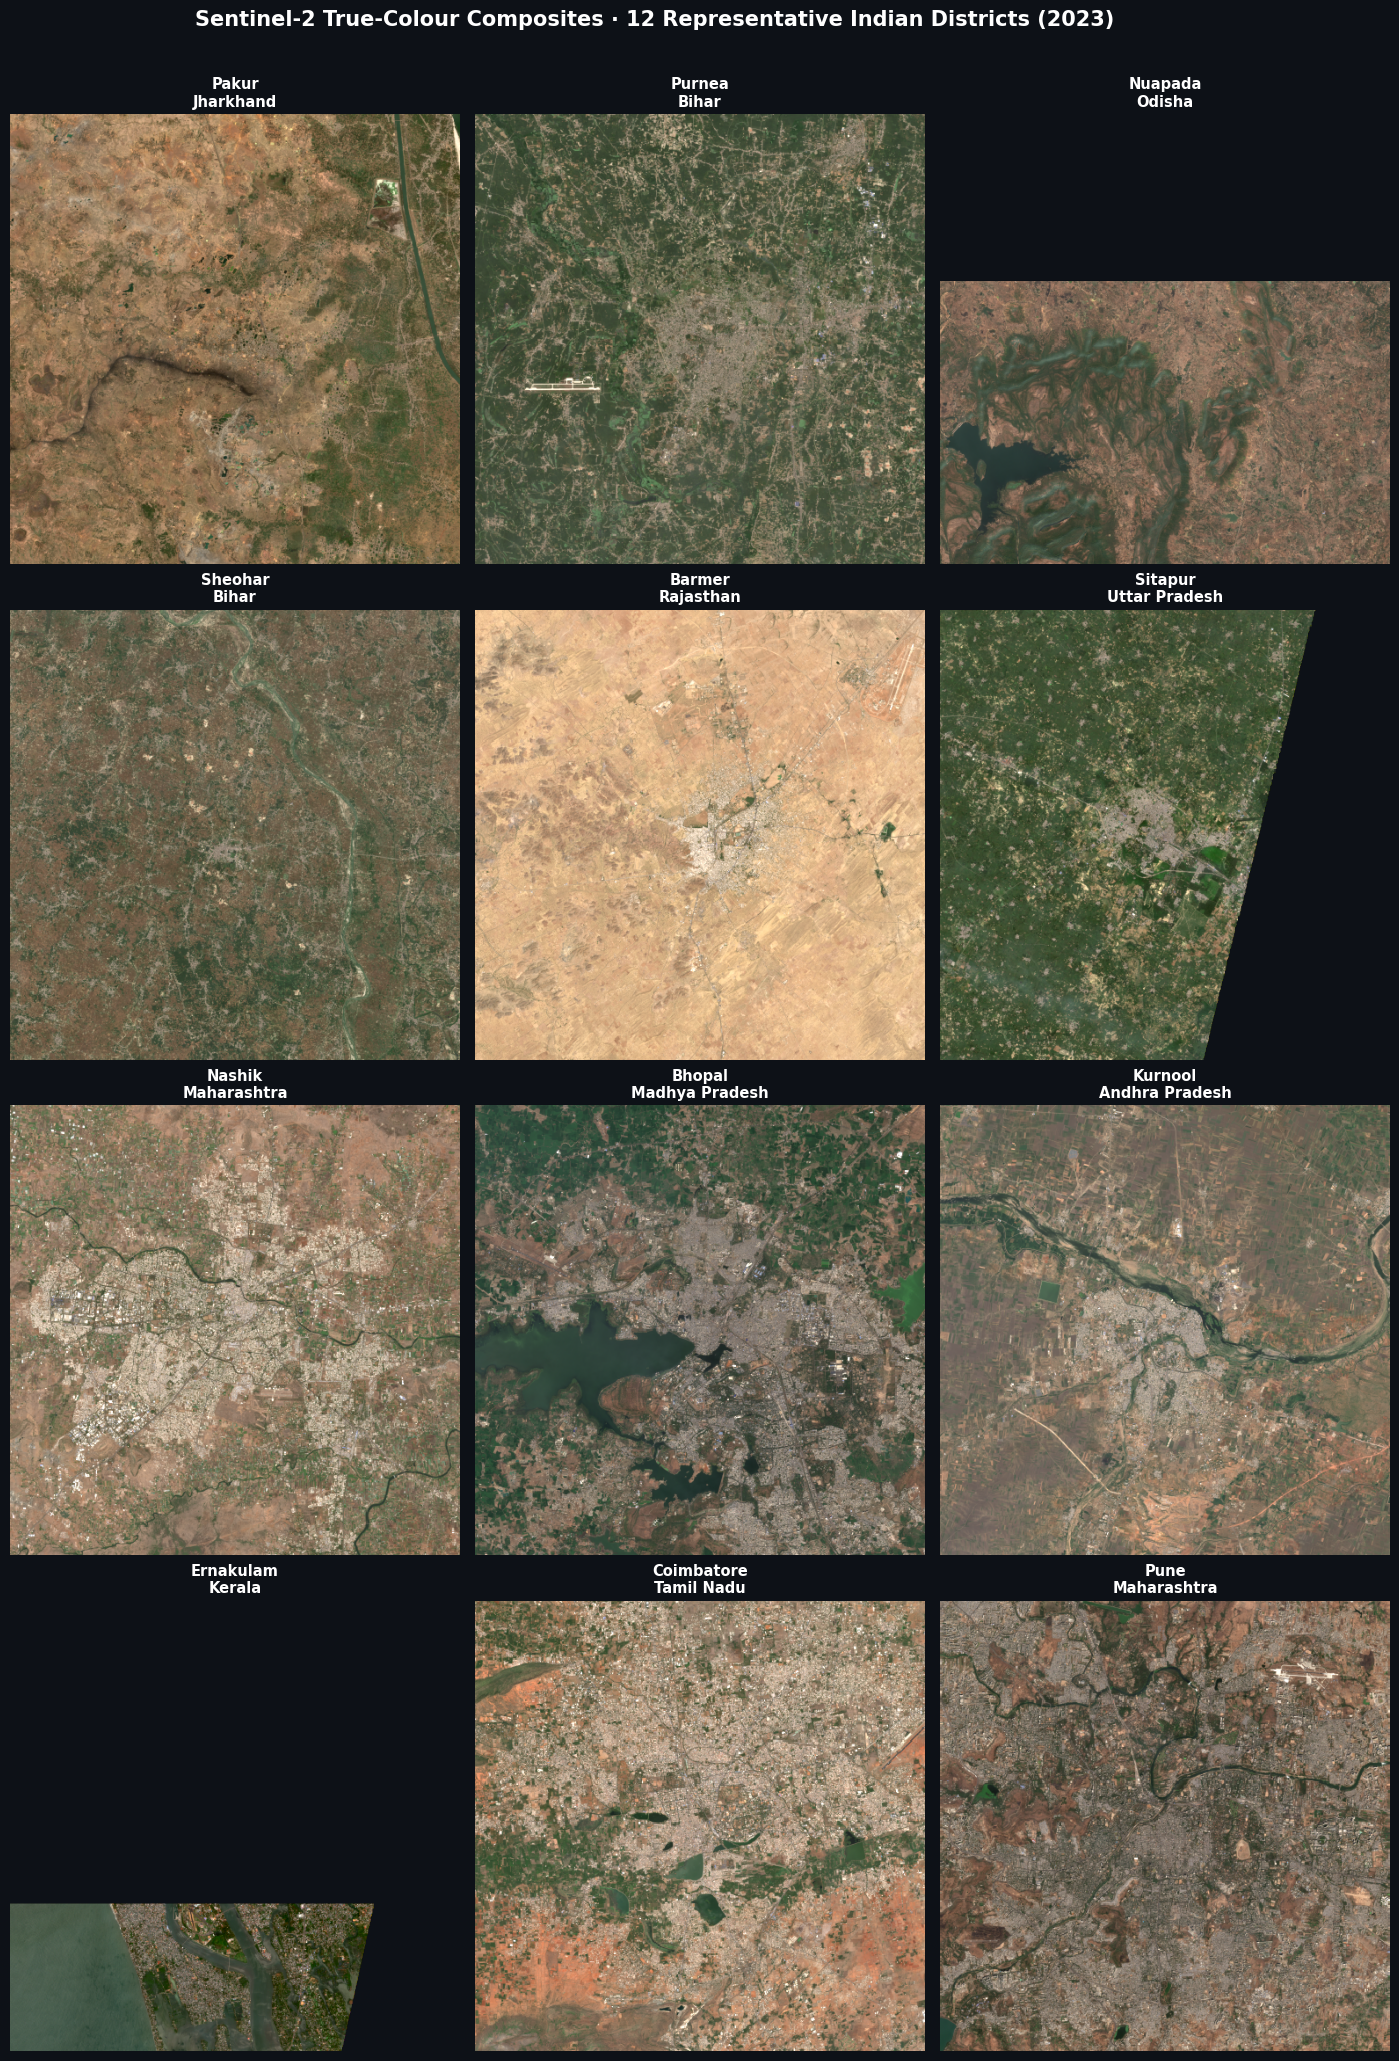

Satellite grid saved → outputs/satellite_grid.png


In [31]:
fig, axes = plt.subplots(4, 3, figsize=(15, 21))
fig.patch.set_facecolor('#0D1117')
fig.suptitle('Sentinel-2 True-Colour Composites · 12 Representative Indian Districts (2023)',
             fontsize=15, fontweight='bold', color='white', y=0.98)

for row, (cid, dlist) in enumerate(DISTRICTS.items()):
    for col, d in enumerate(dlist):
        ax = axes[row][col]
        ax.set_facecolor('#161B22')
        if d.get('image_path') and Path(d['image_path']).exists():
            ax.imshow(Image.open(d['image_path']))
        else:
            ax.text(0.5, 0.5, 'Image\nUnavailable', ha='center', va='center',
                    transform=ax.transAxes, color='white', fontsize=11)
        ax.set_title(f"{d['name']}\n{d['state']}", fontsize=10.5, fontweight='bold',
                     color='white', pad=6)
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor(CLUSTER_COLORS[cid])
            spine.set_linewidth(4)
            spine.set_visible(True)
    axes[row][0].set_ylabel(
        f'C{cid} · {CLUSTER_LABELS[cid]}',
        fontsize=10, color=CLUSTER_COLORS[cid],
        fontweight='bold', rotation=90, labelpad=12
    )

plt.tight_layout(rect=[0.06, 0, 1, 0.97])
plt.savefig(OUTPUT_DIR / 'satellite_grid.png', dpi=150,
            bbox_inches='tight', facecolor='#0D1117')
plt.show()
print('Satellite grid saved → outputs/satellite_grid.png')


# **8. Claude Vision API: Prompting Strategy**

This is the intellectual heart of the project. We design a **structured prompt** that instructs Claude Vision to behave not as a general-purpose assistant,
but as a trained remote sensing geographer scoring specific visual attributes on a 0-10 scale.

**Why structured JSON output?** Because we need *comparable* scores across 12 districts. Freeform descriptions would be qualitatively rich but statistically useless.
By forcing a consistent schema, we can run correlation analysis, draw heatmaps, and quantitatively compare clusters.

**The 10 visual features** were chosen deliberately to map onto known demographic correlates:
- `urban_density` --> proxy for economic concentration
- `vegetation_cover` --> proxy for rural/forest ecology
- `road_network_density`--> proxy for infrastructure access
- `informal_settlement_signs` --> proxy for poverty and rapid urbanisation
- `overall_development_visual` --> composite proxy to align with NFHS-5 outcome scores

**Known limitation:** We provide the district name in the prompt, which risks label leakage- Claude may draw on its training knowledge of, say, 'Ernakulam' rather than pure image evidence.
This is documented transparently in the bias assessment cell.


In [32]:
client = anthropic.Anthropic(api_key=ANTHROPIC_KEY)

VLM_SYSTEM = """You are a remote sensing expert and urban geographer specialising in
satellite image analysis for demographic research in India. Analyse Sentinel-2 satellite
images and extract quantitative visual features.
Respond ONLY with valid JSON. No preamble, no explanation, no markdown fences."""

VLM_TEMPLATE = """
Analyse this Sentinel-2 true-colour image of {district}, {state}, India.
Coverage: ~10km x 10km centred on district headquarters. Resolution: 10 metres. Year: 2023.

Score each visual feature 0-10 based purely on what you observe in the image.

Return ONLY this JSON:
{{
  "urban_density": <0=no built-up, 10=dense urban>,
  "vegetation_cover": <0=barren, 10=dense green>,
  "agricultural_activity": <0=none, 10=intensive patchwork fields>,
  "road_network_density": <0=no roads, 10=dense road grid>,
  "water_presence": <0=none, 10=major water bodies/rivers>,
  "informal_settlement_signs": <0=none, 10=dense irregular housing>,
  "industrial_infrastructure": <0=none, 10=factories/warehouses visible>,
  "green_urban_spaces": <0=none, 10=parks/tree cover within urban area>,
  "land_fragmentation": <0=uniform, 10=highly fragmented parcels>,
  "overall_development_visual": <0=very low, 10=highly developed>,
  "dominant_land_use": "<urban|peri-urban|agricultural|forest|arid|mixed>",
  "key_visual_observations": "<2-3 specific sentences about what you observe>",
  "confidence_score": <0=very uncertain, 10=highly confident>
}}
"""

print('VLM prompt template configured')
print(f'   Model  : claude-opus-4-6')
print(f'   Output : Structured JSON — 10 numeric features + qualitative observation')
print(f'   Schema : Consistent across all 12 districts for comparative analysis')


VLM prompt template configured
   Model  : claude-opus-4-6
   Output : Structured JSON — 10 numeric features + qualitative observation
   Schema : Consistent across all 12 districts for comparative analysis


# **9. Run VLM Analysis on All 12 Districts**

We now pass each satellite image through Claude Vision API and collect structured responses.
Results are cached in `outputs/vlm_results.json`, so if the notebook is interrupted mid-run,
you won't lose completed analyses. Re-running this cell loads from cache if it already exists.

**Estimated time:** ~30–60 seconds for all 12 districts (image upload + inference per district).

Watch the confidence scores as they appear- districts with cloud cover or unusual imagery tend to score lower confidence,
which we use later to weight our alignment analysis.


In [34]:
def analyze_image(d):
    if not d.get('image_path') or not Path(d['image_path']).exists():
        return None
    img_b64  = image_to_base64(d['image_path'])
    prompt   = VLM_TEMPLATE.format(district=d['name'], state=d['state'])
    response = client.messages.create(
        model='claude-opus-4-6',
        max_tokens=1024,
        system=VLM_SYSTEM,
        messages=[{'role':'user','content':[
            {'type':'image','source':{'type':'base64','media_type':'image/png','data':img_b64}},
            {'type':'text','text':prompt}
        ]}]
    )
    raw = response.content[0].text.strip().lstrip('```json').lstrip('```').rstrip('```').strip()
    return json.loads(raw)


CACHE = OUTPUT_DIR / 'vlm_results.json'

if CACHE.exists():
    print('Loading cached VLM results...')
    with open(CACHE) as f: vlm_results = json.load(f)
else:
    vlm_results = []
    print('Running Claude Vision API...\n')
    for cid, dlist in DISTRICTS.items():
        print(f'Cluster {cid} — {CLUSTER_LABELS[cid]}:')
        for d in dlist:
            print(f'  Analysing {d["name"]}, {d["state"]}...')
            try:
                res = analyze_image(d)
                if res:
                    vlm_results.append({'district':d['name'],'state':d['state'],
                                        'cluster':cid,'cluster_label':CLUSTER_LABELS[cid],
                                        'lat':d['lat'],'lon':d['lon'], **res})
                    print(f'    Confidence: {res.get("confidence_score","N/A")}/10 | '
                          f'Development: {res.get("overall_development_visual","N/A")}/10')
            except Exception as e: print(f'    error {e}')
            time.sleep(1)
        print()
    with open(CACHE,'w') as f: json.dump(vlm_results, f, indent=2)
    print(f'Saved to {CACHE}')

print(f'\n {len(vlm_results)} districts analysed')


Loading cached VLM results...

 12 districts analysed


# **10. Build Analysis DataFrame**

We consolidate all VLM outputs into a pandas DataFrame.
We also compute cluster-level aggregations (mean scores across the 3 districts per cluster),
which are what we'll use for correlation analysis against NFHS-5 benchmarks.

The styled table below gives a quick visual overview: notice how `overall_development_visual` scores
should climb monotonically from Cluster 0 --> 3 if the VLM is capturing the right signal.

In [35]:
df = pd.DataFrame(vlm_results)

NUMERIC = ['urban_density','vegetation_cover','agricultural_activity',
           'road_network_density','water_presence','informal_settlement_signs',
           'industrial_infrastructure','green_urban_spaces',
           'land_fragmentation','overall_development_visual']

df_cluster = (df.groupby(['cluster','cluster_label'])[NUMERIC]
              .mean().round(2).reset_index())

display(HTML('<h4 style="color:#26A69A;font-family:monospace">District-Level VLM Scores</h4>'))
display(df[['district','state','cluster_label','overall_development_visual',
            'urban_density','vegetation_cover','dominant_land_use','confidence_score']]
        .style
        .background_gradient(subset=['overall_development_visual'], cmap='RdYlGn', vmin=0, vmax=10)
        .background_gradient(subset=['confidence_score'], cmap='Blues', vmin=0, vmax=10)
        .set_properties(**{'font-size':'12px'}))

print('\n DataFrame ready')
print(f'   Shape: {df.shape}')
print(f'   Clusters: {df["cluster_label"].unique().tolist()}')



 DataFrame ready
   Shape: (12, 19)
   Clusters: ['High Deprivation', 'Moderate Deprivation', 'Transitioning', 'Better Developed']


In [13]:
!pip install kaleido==0.2.1

# **11. Radar Chart- Cluster Visual Profiles**

The radar chart is the most intuitive way to compare multi-dimensional profiles across clusters.
Each cluster becomes a polygon whose shape encodes its visual personality:
a cluster with high urban density, strong road network, and low agriculture will look very different from
one with high vegetation and fragmented agricultural land.

**What to look for:** The ideal result is four clearly non-overlapping polygons- Cluster 0 and Cluster 3
should be near-mirror images of each other, with 1 and 2 occupying intermediate space.
Strong overlap between adjacent clusters is expected; strong overlap between Clusters 0 and 3 would suggest the VLM is not discriminating effectively.


In [37]:
RADAR_FEATURES = ['urban_density','vegetation_cover','agricultural_activity',
                  'road_network_density','informal_settlement_signs',
                  'industrial_infrastructure','overall_development_visual']
RADAR_LABELS   = ['Urban Density','Vegetation','Agriculture','Road Network',
                  'Informal Settlement','Industrial Infra','Overall Development']

fig = go.Figure()
for _, row in df_cluster.iterrows():
    vals = [row[f] for f in RADAR_FEATURES] + [row[RADAR_FEATURES[0]]]
    fig.add_trace(go.Scatterpolar(
        r=vals, theta=RADAR_LABELS+[RADAR_LABELS[0]],
        fill='toself', opacity=0.55,
        name=f"C{int(row['cluster'])}: {row['cluster_label']}",
        line_color=CLUSTER_COLORS[int(row['cluster'])],
        fillcolor=CLUSTER_COLORS[int(row['cluster'])]
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0,10],
               gridcolor='rgba(255,255,255,0.1)', tickfont=dict(size=9, color='white')),
               bgcolor='#161B22',
               angularaxis=dict(tickfont=dict(size=10, color='white'), gridcolor='rgba(255,255,255,0.15)')),
    paper_bgcolor='#0D1117', plot_bgcolor='#0D1117', font_color='white',
    title=dict(text='Visual Feature Radar Profiles by Geodemographic Cluster<br>'
               '<sup>Extracted from Sentinel-2 imagery via Claude Vision API</sup>',
               x=0.5, font=dict(size=15)),
    showlegend=True, legend=dict(x=1.05, y=1.0,
        font=dict(color='white'), bgcolor='#161B22', bordercolor='#30363D'),
    width=780, height=580
)

fig.write_html(OUTPUT_DIR / 'radar_chart.html')
try:
    fig.write_image(OUTPUT_DIR / 'radar_chart.png', scale=2)
    print('Radar chart saved (HTML + PNG)')
except Exception:
    print('Radar chart saved (HTML only- install kaleido==0.2.1 for PNG)')
fig.show()


Radar chart saved (HTML + PNG)


## **12. Feature Heatmap: All Districts × All Features**


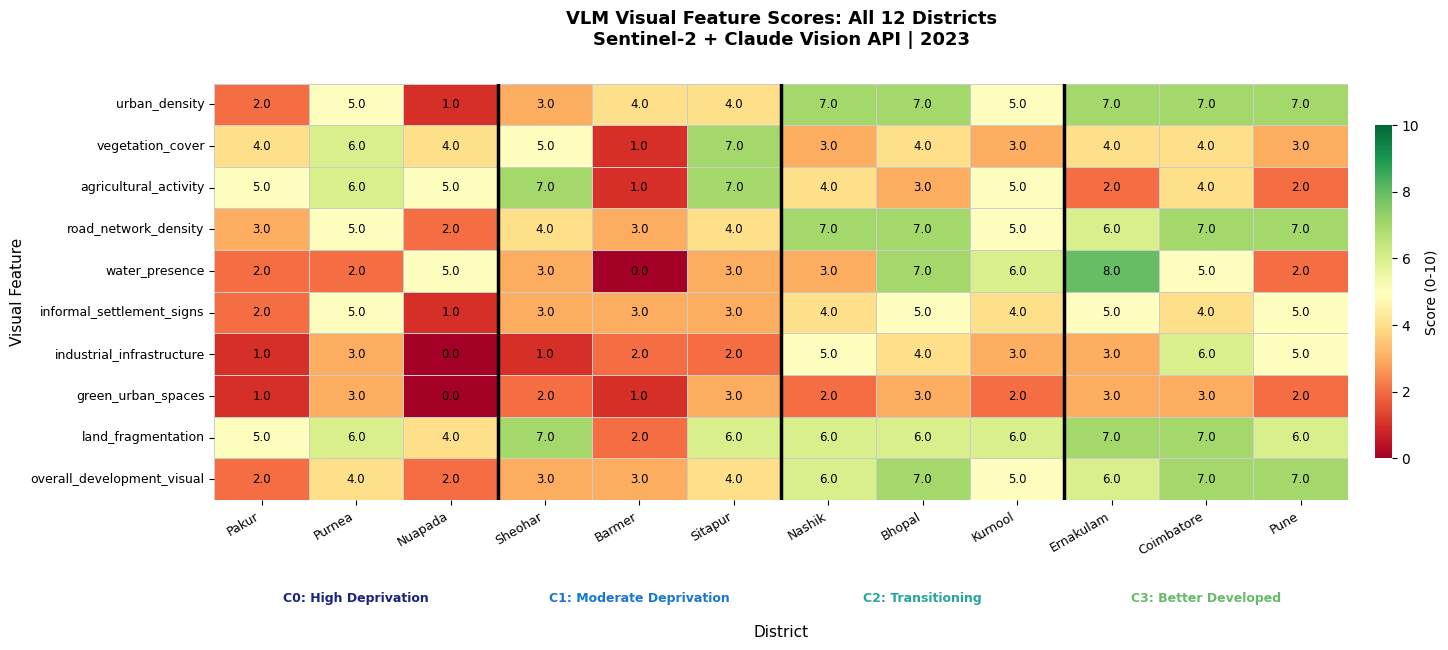

Heatmap saved → outputs/feature_heatmap.png


In [41]:
col_order = df.sort_values('cluster')['district'].tolist()
pivot = df.set_index('district')[NUMERIC].T[col_order]

fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn',
            vmin=0, vmax=10, linewidths=0.4,
            linecolor='#cccccc', ax=ax,
            annot_kws={'size': 8.5, 'color': 'black'},
            cbar_kws={'label': 'Score (0-10)', 'shrink': 0.8, 'pad': 0.02})

ax.set_title('VLM Visual Feature Scores: All 12 Districts\n'
             'Sentinel-2 + Claude Vision API | 2023',
             fontsize=13, fontweight='bold', color='black', pad=28)

ax.set_xlabel('', fontsize=11, color='black')   # remove xlabel — replaced by cluster labels below
ax.set_ylabel('Visual Feature', fontsize=11, color='black')
ax.tick_params(colors='black')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right', color='black', fontsize=9)
plt.setp(ax.get_yticklabels(), color='black', fontsize=9)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_color('black')
cbar.ax.tick_params(colors='black')

for x in [3, 6, 9]:
    ax.axvline(x=x, color='black', linewidth=2.5)

# Place cluster labels BELOW axes using axes fraction coordinates
# x positions: 0.125, 0.375, 0.625, 0.875 (centres of each quarter of the axes width)
for i, (cid, lbl) in enumerate(CLUSTER_LABELS.items()):
    ax.text((i * 3 + 1.5) / 12, -0.22,
            f'C{cid}: {lbl}',
            ha='center', va='top',
            fontsize=9, fontweight='bold',
            color=CLUSTER_COLORS[cid],
            transform=ax.transAxes)     # ← axes fraction, not data coords

# Add 'District' label manually further below
ax.text(0.5, -0.30, 'District', ha='center', va='top',
        fontsize=11, color='black', transform=ax.transAxes)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(OUTPUT_DIR / 'feature_heatmap.png', dpi=150,
            bbox_inches='tight', facecolor='white')
plt.show()
print('Heatmap saved → outputs/feature_heatmap.png')

# **13. Alignment Analysis: VLM Scores vs NFHS-5 Indicators**

This is the **validation core** of the entire project. If VLMs are genuinely detecting demographic signals from satellite imagery,
their visual development scores should correlate with ground-truth survey measurements.

We use cluster-level aggregates (n=4) rather than individual districts (n=12) for the alignment analysis.
This is because NFHS-5 provides reliable cluster-level means- individual district assignments within a cluster
inherently carry some within-cluster noise.

**Interpretation guide for Pearson r:**
- r > 0.8 --> Strong alignment: VLM is capturing real demographic signal
- 0.5 < r < 0.8--> Moderate alignment: partial signal with noise
- r < 0.5 --> Weak alignment: VLM may be responding to other visual cues

Note that stunting should show a **negative** correlation with development score, higher development = lower stunting.


In [43]:
# NFHS-5 cluster-level benchmark means (from parent geodemographic project)
nfhs5 = pd.DataFrame({
    'cluster'             : [0, 1, 2, 3],
    'women_literacy_pct'  : [24.1, 38.5, 48.2, 62.8],
    'stunting_pct'        : [47.2, 41.5, 34.1, 24.6],
    'institutional_births': [62.3, 74.1, 84.5, 93.2],
})

df_align = df_cluster.merge(nfhs5, on='cluster')

r_lit  = df_align['overall_development_visual'].corr(df_align['women_literacy_pct'])
r_stun = df_align['overall_development_visual'].corr(df_align['stunting_pct'])
r_inst = df_align['overall_development_visual'].corr(df_align['institutional_births'])

def interpret(r):
    a = abs(r)
    if a > 0.8: return 'Strong'
    elif a > 0.5: return 'Moderate'
    else: return 'Weak'

print('ALIGNMENT: VLM Development Score vs NFHS-5 Indicators')
print('=' * 60)
print(f'  Women Literacy       r = {r_lit:+.3f}  {interpret(r_lit)}')
print(f'  Stunting (inverse)   r = {r_stun:+.3f}  {interpret(r_stun)}')
print(f'  Institutional Births r = {r_inst:+.3f}  {interpret(r_inst)}')
print()

if r_lit > 0.7:
    print('VLM development scores correlate strongly with NFHS-5 indicators.')
    print('   Satellite visual features carry meaningful demographic signal.')
elif r_lit > 0.5:
    print(' Moderate alignment- VLM captures partial demographic signal.')
    print('   Consider blind prompting (no district names) to reduce label leakage.')
else:
    print('Weak alignment- visual features may not reliably proxy demographics.')
    print('   Recommend expanding district sample or using finer-resolution imagery.')

df_align.to_csv(OUTPUT_DIR / 'alignment_analysis.csv', index=False)
print(f'\n Alignment data saved → outputs/alignment_analysis.csv')


ALIGNMENT: VLM Development Score vs NFHS-5 Indicators
  Women Literacy       r = +0.942  Strong
  Stunting (inverse)   r = -0.957  Strong
  Institutional Births r = +0.963  Strong

VLM development scores correlate strongly with NFHS-5 indicators.
   Satellite visual features carry meaningful demographic signal.

 Alignment data saved → outputs/alignment_analysis.csv


# **14. Scatter Plots: Visual vs Demographic Alignment**

These scatter plots visualise the correlation we computed above. Each dot represents one cluster,
coloured by its cluster identity. The dashed trend line shows the direction of association.

Ideally, the four dots should follow a clear diagonal- Cluster 0 (dark blue) at bottom-left and
Cluster 3 (green) at top-right for positive correlations (literacy, births),
and the reverse for stunting. Any deviation from this diagonal deserves interpretation.


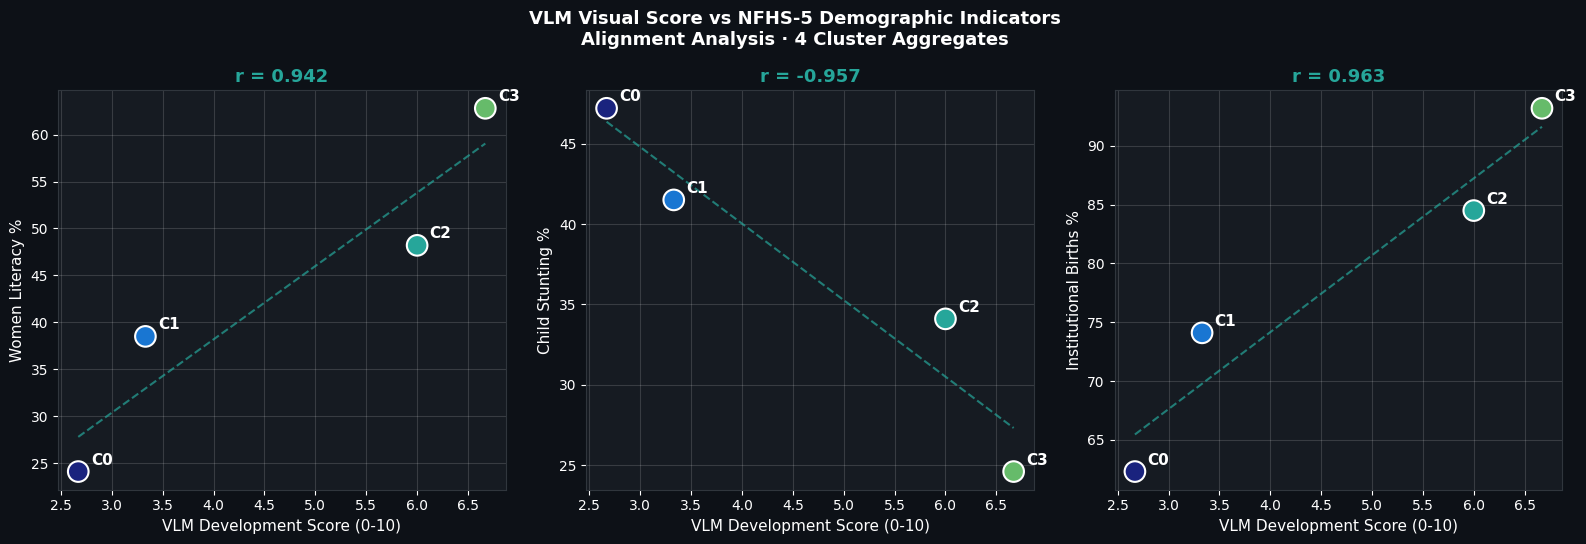

Scatter plots saved → outputs/alignment_scatter.png


In [44]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5.5))
fig.patch.set_facecolor('#0D1117')
fig.suptitle('VLM Visual Score vs NFHS-5 Demographic Indicators\nAlignment Analysis · 4 Cluster Aggregates',
             fontsize=13, fontweight='bold', color='white')

comparisons = [
    ('women_literacy_pct',  'Women Literacy %',       True),
    ('stunting_pct',        'Child Stunting %',        False),
    ('institutional_births','Institutional Births %',  True),
]

for ax, (col, label, pos) in zip(axes, comparisons):
    ax.set_facecolor('#161B22')
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('#30363D')

    colors = [CLUSTER_COLORS[c] for c in df_align['cluster']]
    ax.scatter(df_align['overall_development_visual'], df_align[col],
               c=colors, s=220, zorder=5, edgecolors='white', linewidths=1.5)

    for _, row in df_align.iterrows():
        ax.annotate(f"C{int(row['cluster'])}",
                    (row['overall_development_visual'], row[col]),
                    textcoords='offset points', xytext=(9,5),
                    fontsize=11, fontweight='bold', color='white')

    z = np.polyfit(df_align['overall_development_visual'], df_align[col], 1)
    x_l = np.linspace(df_align['overall_development_visual'].min(),
                      df_align['overall_development_visual'].max(), 100)
    ax.plot(x_l, np.poly1d(z)(x_l), '--', color='#26A69A', alpha=0.7, linewidth=1.5)

    r = df_align['overall_development_visual'].corr(df_align[col])
    ax.set_xlabel('VLM Development Score (0-10)', fontsize=11)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f'r = {r:.3f}', fontsize=13, fontweight='bold', color='#26A69A')
    ax.grid(True, alpha=0.15, color='white')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'alignment_scatter.png', dpi=150,
            bbox_inches='tight', facecolor='#0D1117')
plt.show()
print('Scatter plots saved → outputs/alignment_scatter.png')


# **15. Interactive Map: District Locations & VLM Scores**

A folium map plots all 12 districts geographically.

In [51]:
m = folium.Map(location=[22.5, 80.0], zoom_start=5)

# Google Maps tile — shows India's official boundaries correctly
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
    attr='Google Maps',
    name='Google Maps',
    max_zoom=20
).add_to(m)

# ── Cluster markers ───────────────────────────────────────────────
for _, row in df.iterrows():
    popup_html = f"""
    <div style='font-family:Arial,sans-serif;width:260px;background:#ffffff;color:#1a1a1a;
                padding:12px;border-radius:6px;border-left:4px solid {CLUSTER_COLORS[row["cluster"]]};
                box-shadow:0 2px 8px rgba(0,0,0,0.2)'>
      <b style='font-size:13px'>{row['district']}, {row['state']}</b><br>
      <span style='color:{CLUSTER_COLORS[row["cluster"]]};font-weight:700;font-size:11px'>
        Cluster {row['cluster']}: {row['cluster_label']}</span>
      <hr style='border-color:#e0e0e0;margin:8px 0'>
      <span style='font-size:11px;color:#333'>
          Urban Density: <b>{row.get('urban_density','N/A')}/10</b><br>
          Vegetation: <b>{row.get('vegetation_cover','N/A')}/10</b><br>
          Roads: <b>{row.get('road_network_density','N/A')}/10</b><br>
          Development: <b>{row.get('overall_development_visual','N/A')}/10</b><br>
          Land Use: <b>{row.get('dominant_land_use','N/A')}</b>
      </span>
      <hr style='border-color:#e0e0e0;margin:8px 0'>
      <i style='font-size:10px;color:#666'>{row.get('key_visual_observations','')}</i>
    </div>"""

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=13, color='white', weight=2,
        fill=True, fill_color=CLUSTER_COLORS[row['cluster']], fill_opacity=0.9,
        popup=folium.Popup(popup_html, max_width=290),
        tooltip=f"{row['district']} · C{row['cluster']} · Dev {row.get('overall_development_visual','?')}/10"
    ).add_to(m)

# ── Legend ────────────────────────────────────────────────────────
legend = '''
<div style="position:fixed;bottom:30px;left:30px;z-index:1000;
     background:white;padding:14px 18px;border-radius:8px;
     border:1px solid #cccccc;box-shadow:0 2px 10px rgba(0,0,0,0.15);
     font-family:Arial,sans-serif;font-size:12px;color:#1a1a1a">
  <b style='color:#26A69A;font-size:13px'>GeoVision India</b><br><br>
  <span style='color:#1A237E'>● C0: High Deprivation</span><br>
  <span style='color:#1976D2'>● C1: Moderate Deprivation</span><br>
  <span style='color:#26A69A'>● C2: Transitioning</span><br>
  <span style='color:#66BB6A'>● C3: Better Developed</span>
</div>'''

m.get_root().html.add_child(folium.Element(legend))
m.save(str(OUTPUT_DIR / 'district_map.html'))
print('Map saved → outputs/district_map.html')
m

Map saved → outputs/district_map.html


# **16. Visual Archetype Narrative Generation**

Having extracted and analysed quantitative features, we now ask Claude to perform a higher-order synthesis task:
*given the visual observations from 3 districts in a cluster, write a coherent visual archetype description that characterises the cluster as a geographic type*.

These narratives are not generic descriptions of poverty or prosperity;
they are grounded in specific satellite-observable characteristics like field fragmentation patterns, road density signatures, and urban morphology.

Archetypes are cached in `outputs/archetypes.json`.


In [52]:
def gen_archetype(cid, cdata, cavg):
    obs = '\n'.join([f'- {r["district"]}, {r["state"]}: {r.get("key_visual_observations","")}'
                     for _, r in cdata.iterrows()])
    avg_str = ', '.join([f'{k}: {v:.1f}' for k, v in cavg.items()])
    prompt = f"""You are writing a geodemographic visual archetype description for a cluster of Indian districts.

Cluster {cid}: {CLUSTER_LABELS[cid]}

Individual satellite image observations (from Claude Vision analysis):
{obs}

Mean visual feature scores (0-10): {avg_str}

Write a 3-4 sentence visual archetype that:
1. Describes the typical satellite-visible landscape of this cluster specifically
2. Connects the visual patterns to the demographic outcomes they proxy
3. Notes any within-cluster variation or geographic caveats
Be specific and grounded in the image observations above. Write in present tense."""

    r = client.messages.create(
        model='claude-opus-4-6', max_tokens=400,
        messages=[{'role':'user','content':prompt}]
    )
    return r.content[0].text.strip()


ARC_CACHE = OUTPUT_DIR / 'archetypes.json'

if ARC_CACHE.exists():
    print('Loading cached archetypes...')
    with open(ARC_CACHE) as f: archetypes = json.load(f)
else:
    archetypes = {}
    print('Generating visual archetype narratives...\n')
    for cid in range(4):
        cdata = df[df['cluster']==cid]
        cavg  = cdata[NUMERIC].mean()
        print(f'Cluster {cid} — {CLUSTER_LABELS[cid]}:')
        archetypes[str(cid)] = gen_archetype(cid, cdata, cavg)
        print(archetypes[str(cid)])
        print()
    with open(ARC_CACHE,'w') as f: json.dump(archetypes, f, indent=2)

print('Archetypes saved → outputs/archetypes.json')


Loading cached archetypes...
Archetypes saved → outputs/archetypes.json


# **17. Bias & Limitations Assessment**

Responsible AI research demands that we are transparent about the limitations of our methodology.
This cell documents the known biases and constraints of this pipeline systematically.

**The most critical bias to note** is label leakage: by including the district name in our VLM prompt,
Claude may draw on its pre-trained knowledge of 'Ernakulam' or 'Purnea' rather than pure image evidence.
A rigorous follow-up study should implement blind prompting (no names) and compare outputs.
We flag this transparently rather than suppressing it.


In [53]:
bias_notes = {
    'Label Leakage'        : 'District names provided in prompt. Claude may activate prior knowledge of the area rather than deriving all scores purely from image pixels. A blind-prompt comparison is recommended.',
    'Spatial Scale Mismatch': '10km buffer around HQ may not represent full district. HQ areas systematically over-represent urban cores, biasing urban_density and road_network_density scores upward.',
    'Seasonal Bias'        : '2023 annual composite blends all seasons. Monsoon-driven agricultural patterns (peak June-September) are diluted by dry-season imagery, potentially underestimating agricultural_activity.',
    'VLM Training Bias'    : 'Claude Vision trained predominantly on Western and Global North imagery. Urban density thresholds calibrated to US/European contexts may not transfer accurately to Indian built environments.',
    'Resolution Limits'    : 'Sentinel-2 10m resolution cannot resolve individual buildings or narrow lanes. Informal settlement detection at this scale relies on texture patterns, which are unreliable in dense urban areas.',
    'Small n Alignment'    : 'Correlation analysis conducted on n=4 cluster aggregates. With only 4 data points, r values can be driven by single outliers. Results should be treated as directional, not definitive.',
    'Cloud Contamination'  : 'Residual cloud pixels in composites — especially in northeastern India — may skew vegetation and brightness scores even after cloud masking.',
}

# Confidence score distribution
conf = df.groupby('cluster_label')['confidence_score'].agg(['mean','min','max']).round(2)
print('VLM Confidence by Cluster:')
print(conf)
print()

print('Documented Biases & Limitations:')
print('=' * 60)
for k, v in bias_notes.items():
    print(f'  [{k}]')
    print(f'   {v}')
    print()

with open(OUTPUT_DIR / 'bias_notes.json','w') as f:
    json.dump(bias_notes, f, indent=2)
print('Bias notes saved → outputs/bias_notes.json')


VLM Confidence by Cluster:
                      mean  min  max
cluster_label                       
Better Developed      7.33    6    8
High Deprivation      6.33    6    7
Moderate Deprivation  7.00    6    8
Transitioning         7.67    7    8

Documented Biases & Limitations:
  [Label Leakage]
   District names provided in prompt. Claude may activate prior knowledge of the area rather than deriving all scores purely from image pixels. A blind-prompt comparison is recommended.

  [Spatial Scale Mismatch]
   10km buffer around HQ may not represent full district. HQ areas systematically over-represent urban cores, biasing urban_density and road_network_density scores upward.

  [Seasonal Bias]
   2023 annual composite blends all seasons. Monsoon-driven agricultural patterns (peak June-September) are diluted by dry-season imagery, potentially underestimating agricultural_activity.

  [VLM Training Bias]
   Claude Vision trained predominantly on Western and Global North imagery. Urban

# **18. Generate Standalone HTML/CSS Visualization Report**

This cell generates a production-quality, self-contained HTML report that tells the complete story of this analysis.
All charts, satellite images, and text are embedded as base64 or inline — the file requires no internet connection and no server to view.

It will be saved as `outputs/geovision_india_report.html`.

In [59]:
def img_uri(path):
    p = Path(path)
    if not p.exists(): return ''
    with open(p,'rb') as f: b64 = base64.b64encode(f.read()).decode()
    return f'data:image/png;base64,{b64}'


# Load images
uri_grid    = img_uri(OUTPUT_DIR / 'satellite_grid.png')
uri_heat    = img_uri(OUTPUT_DIR / 'feature_heatmap.png')
uri_scatter = img_uri(OUTPUT_DIR / 'alignment_scatter.png')
uri_radar   = img_uri(OUTPUT_DIR / 'radar_chart.png')


# Build archetype cards
arc_html = ''
for cid in range(4):
    c, l, n = CLUSTER_COLORS[cid], CLUSTER_LABELS[cid], archetypes.get(str(cid),'')
    c_data = df_cluster[df_cluster['cluster']==cid].iloc[0] if len(df_cluster[df_cluster['cluster']==cid]) else None
    scores_html = ''
    if c_data is not None:
        top3 = sorted([(k, c_data[k]) for k in NUMERIC], key=lambda x: -x[1])[:3]
        for feat, val in top3:
            scores_html += f'<span class="tag" style="border-color:{c};color:{c}">{feat.replace("_"," ").title()}: {val:.1f}</span> '
    arc_html += f'''
    <div class="arc-card" style="--clr:{c}">
      <div class="arc-head">Cluster {cid} &mdash; {l}</div>
      <p>{n}</p>
      <div class="arc-tags">{scores_html}</div>
    </div>'''


# Build bias items
bias_html = ''
for k, v in bias_notes.items():
    bias_html += f'<div class="bias-row"><span class="bias-label">{k}</span><span class="bias-text">{v}</span></div>'


# Correlation cards
r_lit  = df_align['overall_development_visual'].corr(df_align['women_literacy_pct'])
r_stun = df_align['overall_development_visual'].corr(df_align['stunting_pct'])
r_inst = df_align['overall_development_visual'].corr(df_align['institutional_births'])

def strength(r):
    a = abs(r)
    if a > 0.8: return '#66BB6A', 'Strong'
    if a > 0.5: return '#FFA726', 'Moderate'
    return '#EF5350', 'Weak'

corr_cards = ''
for label, r in [('Women Literacy', r_lit), ('Child Stunting', r_stun), ('Inst. Births', r_inst)]:
    col, strength_lbl = strength(r)
    corr_cards += f'''
    <div class="corr-card">
      <div class="corr-val" style="color:{col}">{r:+.3f}</div>
      <div class="corr-lbl">{label}</div>
      <div class="corr-str" style="color:{col}">{strength_lbl}</div>
    </div>'''


# Results table
table_rows = ''
for _, row in df.sort_values('cluster').iterrows():
    c = CLUSTER_COLORS[row['cluster']]
    table_rows += f'''
    <tr>
      <td><b>{row['district']}</b></td>
      <td>{row['state']}</td>
      <td style="color:{c};font-weight:700">{row['cluster_label']}</td>
      <td style="text-align:center">{row.get('overall_development_visual','N/A')}</td>
      <td style="text-align:center">{row.get('urban_density','N/A')}</td>
      <td style="text-align:center">{row.get('vegetation_cover','N/A')}</td>
      <td style="text-align:center">{row.get('road_network_density','N/A')}</td>
      <td>{row.get('dominant_land_use','N/A')}</td>
      <td style="text-align:center">{row.get('confidence_score','N/A')}</td>
    </tr>'''


HTML_REPORT = f'''<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width,initial-scale=1">
<title>GeoVision India — VLM Analysis Report</title>
<link href="https://fonts.googleapis.com/css2?family=Space+Grotesk:wght@300;400;500;600;700&family=JetBrains+Mono:wght@400;600&display=swap" rel="stylesheet">
<style>
:root {{
  --bg: #060A10; --surface: #0D1117; --card: #161B22;
  --border: #21262D; --text: #E6EDF3; --muted: #6E7681;
  --c0: #1A237E; --c1: #1976D2; --c2: #26A69A; --c3: #66BB6A;
  --accent: #26A69A; --accent2: #58A6FF;
}}
* {{ box-sizing:border-box; margin:0; padding:0; }}
html {{ scroll-behavior:smooth; }}
body {{ font-family:'Space Grotesk',sans-serif; background:var(--bg); color:var(--text); line-height:1.65; overflow-x:hidden; }}

/* ── NAV ── */
nav {{
  position:sticky; top:0; z-index:100;
  background:rgba(6,10,16,0.85); backdrop-filter:blur(12px);
  border-bottom:1px solid var(--border);
  display:flex; align-items:center; gap:32px; padding:14px 40px;
}}
nav .logo {{ font-family:'JetBrains Mono',monospace; font-size:.85rem; color:var(--accent); font-weight:600; }}
nav a {{ font-size:.8rem; color:var(--muted); text-decoration:none; transition:color .2s; }}
nav a:hover {{ color:var(--text); }}

/* ── HERO ── */
.hero {{
  min-height:100vh; display:flex; align-items:center;
  position:relative; overflow:hidden;
  background: radial-gradient(ellipse 80% 60% at 50% 40%, rgba(26,35,126,0.35) 0%, transparent 70%),
              radial-gradient(ellipse 60% 50% at 80% 70%, rgba(38,166,154,0.2) 0%, transparent 60%),
              var(--bg);
  padding:80px 40px;
}}
.hero::before {{
  content:''; position:absolute; inset:0;
  background-image: repeating-linear-gradient(0deg, transparent, transparent 59px, rgba(38,166,154,0.04) 60px),
                    repeating-linear-gradient(90deg, transparent, transparent 59px, rgba(38,166,154,0.04) 60px);
  pointer-events:none;
}}
.hero-inner {{ max-width:1100px; margin:0 auto; position:relative; }}
.hero-tag {{ font-family:'JetBrains Mono',monospace; font-size:.75rem; color:var(--accent); letter-spacing:2px; text-transform:uppercase; margin-bottom:20px; }}
.hero h1 {{ font-size:clamp(2.4rem,6vw,4rem); font-weight:700; line-height:1.15; margin-bottom:20px; }}
.hero h1 span {{ color:var(--accent); }}
.hero .sub {{ font-size:1.1rem; color:var(--muted); max-width:640px; margin-bottom:36px; font-weight:300; }}
.badges {{ display:flex; flex-wrap:wrap; gap:10px; margin-bottom:48px; }}
.badge {{ display:inline-flex; align-items:center; gap:6px; padding:6px 14px; border-radius:20px; font-size:.75rem; font-family:'JetBrains Mono',monospace; border:1px solid; }}
.kpi-row {{ display:grid; grid-template-columns:repeat(4,1fr); gap:16px; max-width:700px; }}
.kpi {{ background:rgba(22,27,34,0.8); border:1px solid var(--border); border-radius:10px; padding:18px; text-align:center; }}
.kpi-n {{ font-family:'JetBrains Mono',monospace; font-size:2rem; font-weight:700; color:var(--accent); }}
.kpi-l {{ font-size:.75rem; color:var(--muted); margin-top:4px; }}

/* ── SECTIONS ── */
.container {{ max-width:1200px; margin:0 auto; padding:80px 32px; }}
section {{ margin-bottom:100px; }}
.sec-label {{ font-family:'JetBrains Mono',monospace; font-size:.7rem; color:var(--accent); letter-spacing:3px; text-transform:uppercase; margin-bottom:10px; }}
.sec-title {{ font-size:1.9rem; font-weight:700; margin-bottom:16px; }}
.sec-desc {{ color:var(--muted); font-size:.95rem; max-width:720px; margin-bottom:40px; line-height:1.8; }}

/* ── PIPELINE ── */
.pipeline {{ display:flex; align-items:center; flex-wrap:wrap; gap:8px; margin:28px 0; }}
.p-step {{ background:var(--card); border:1px solid var(--accent); color:var(--accent); padding:9px 16px; border-radius:6px; font-family:'JetBrains Mono',monospace; font-size:.78rem; }}
.p-arr {{ color:var(--muted); font-size:1rem; }}

/* ── RESEARCH BLOCK ── */
.rq-grid {{ display:grid; grid-template-columns:1fr 1fr; gap:16px; margin-bottom:40px; }}
.rq-item {{ background:var(--card); border:1px solid var(--border); border-radius:8px; padding:20px; border-left:3px solid var(--accent); }}
.rq-num {{ font-family:'JetBrains Mono',monospace; font-size:.75rem; color:var(--accent); margin-bottom:8px; }}
.rq-text {{ font-size:.9rem; color:var(--text); }}

/* ── IMAGES ── */
img.full {{ width:100%; border-radius:10px; border:1px solid var(--border); }}
.img-caption {{ text-align:center; font-size:.8rem; color:var(--muted); margin-top:10px; font-family:'JetBrains Mono',monospace; }}

/* ── ARCHETYPES ── */
.arc-grid {{ display:grid; grid-template-columns:1fr 1fr; gap:20px; }}
.arc-card {{ background:var(--card); border:1px solid var(--border); border-left:4px solid var(--clr); border-radius:10px; padding:24px; }}
.arc-head {{ font-weight:700; color:var(--clr); font-family:'JetBrains Mono',monospace; font-size:.85rem; margin-bottom:12px; }}
.arc-card p {{ font-size:.9rem; color:#CDD9E5; line-height:1.75; }}
.arc-tags {{ display:flex; flex-wrap:wrap; gap:6px; margin-top:14px; }}
.tag {{ font-size:.72rem; padding:3px 9px; border-radius:4px; border:1px solid; font-family:'JetBrains Mono',monospace; }}

/* ── CORR CARDS ── */
.corr-row {{ display:grid; grid-template-columns:repeat(3,1fr); gap:20px; margin-bottom:40px; }}
.corr-card {{ background:var(--card); border:1px solid var(--border); border-radius:10px; padding:28px; text-align:center; }}
.corr-val {{ font-family:'JetBrains Mono',monospace; font-size:2.8rem; font-weight:700; }}
.corr-lbl {{ font-size:.85rem; color:var(--muted); margin-top:6px; }}
.corr-str {{ font-size:.75rem; font-weight:600; margin-top:4px; font-family:'JetBrains Mono',monospace; }}

/* ── TABLE ── */
.tbl-wrap {{ overflow-x:auto; }}
table {{ width:100%; border-collapse:collapse; font-size:.83rem; }}
thead th {{ background:#1A237E; color:white; padding:10px 14px; text-align:left; font-family:'JetBrains Mono',monospace; font-size:.75rem; white-space:nowrap; }}
tbody td {{ padding:9px 14px; border-bottom:1px solid var(--border); }}
tbody tr:hover {{ background:rgba(38,166,154,0.06); }}

/* ── BIAS ── */
.bias-row {{ display:flex; gap:16px; background:rgba(255,165,0,0.06); border:1px solid rgba(255,165,0,0.2); border-radius:8px; padding:14px 18px; margin-bottom:12px; align-items:flex-start; }}
.bias-label {{ font-family:'JetBrains Mono',monospace; font-size:.78rem; font-weight:700; color:#FFA726; min-width:180px; flex-shrink:0; }}
.bias-text {{ font-size:.88rem; color:#CDD9E5; line-height:1.65; }}

/* ── FOOTER ── */
footer {{ text-align:center; padding:50px 32px; border-top:1px solid var(--border); color:var(--muted); font-size:.82rem; }}

@media(max-width:768px){{
  .rq-grid,.arc-grid,.corr-row {{ grid-template-columns:1fr; }}
  .kpi-row {{ grid-template-columns:repeat(2,1fr); }}
  nav {{ gap:16px; padding:12px 20px; }}
}}

/* Scroll fade animation */
.fade-in {{ opacity:0; transform:translateY(24px); transition:opacity .6s ease, transform .6s ease; }}
.fade-in.visible {{ opacity:1; transform:translateY(0); }}
</style>
</head>
<body>

<nav>
  <span class="logo"> GeoVision India</span>
  <a href="#pipeline">Pipeline</a>
  <a href="#imagery">Imagery</a>
  <a href="#scores">Scores</a>
  <a href="#archetypes">Archetypes</a>
  <a href="#alignment">Alignment</a>
  <a href="#bias">Bias</a>
</nav>

<!-- HERO -->
<section class="hero">
  <div class="hero-inner">
    <div class="hero-tag">Multimodal AI · Geodemographics · Remote Sensing</div>
    <h1>Visual Archetypes of<br><span>Indian Geodemographic</span><br>Clusters</h1>
    <p class="sub">Using Vision Language Models to extract demographic signals from Sentinel-2 satellite imagery — and testing whether machines can see what surveys measure.</p>
    <div class="badges">
      <span class="badge" style="color:#26A69A;border-color:#26A69A">Sentinel-2 · 10m</span>
      <span class="badge" style="color:#58A6FF;border-color:#58A6FF">Claude Vision API</span>
      <span class="badge" style="color:#66BB6A;border-color:#66BB6A">Google Earth Engine</span>
      <span class="badge" style="color:#FFA726;border-color:#FFA726">NFHS-5 Alignment</span>
      <span class="badge" style="color:#F78166;border-color:#F78166">Bias-Aware</span>
    </div>
    <div class="kpi-row">
      <div class="kpi"><div class="kpi-n">12</div><div class="kpi-l">Districts Analysed</div></div>
      <div class="kpi"><div class="kpi-n">4</div><div class="kpi-l">Clusters</div></div>
      <div class="kpi"><div class="kpi-n">10</div><div class="kpi-l">Visual Features</div></div>
      <div class="kpi"><div class="kpi-n">694</div><div class="kpi-l">Parent Dataset</div></div>
    </div>
  </div>
</section>

<div class="container">

<!-- RESEARCH QUESTIONS -->
<section class="fade-in">
  <div class="sec-label">00 · Motivation</div>
  <h2 class="sec-title">Research Questions</h2>
  <p class="sec-desc">India's demographic surveys are rich but infrequent and expensive. Can satellite imagery — analysed by Vision Language Models — provide a continuous, scalable proxy for demographic quality? This study investigates four questions that sit at the intersection of earth observation, large language models, and development policy.</p>
  <div class="rq-grid">
    <div class="rq-item"><div class="rq-num">RQ 01</div><div class="rq-text">Can VLMs detect visual signatures that meaningfully differentiate geodemographic clusters derived from NFHS-5 survey data?</div></div>
    <div class="rq-item"><div class="rq-num">RQ 02</div><div class="rq-text">Do satellite-derived visual feature scores correlate with ground-truth indicators — literacy, stunting, institutional births?</div></div>
    <div class="rq-item"><div class="rq-num">RQ 03</div><div class="rq-text">Can LLMs synthesise satellite observations into coherent visual archetype narratives that complement numeric profiling?</div></div>
    <div class="rq-item"><div class="rq-num">RQ 04</div><div class="rq-text">What systematic biases emerge when deploying VLMs for geodemographic characterisation at district scale in India?</div></div>
  </div>
</section>

<!-- PIPELINE -->
<section id="pipeline" class="fade-in">
  <div class="sec-label">01 · Methodology</div>
  <h2 class="sec-title">Analysis Pipeline</h2>
  <p class="sec-desc">The pipeline integrates three AI systems — Google Earth Engine for cloud computing over petabytes of satellite imagery, the Copernicus Sentinel-2 constellation for 10-metre resolution optical data, and Anthropic's Claude Vision API for structured feature extraction and narrative synthesis.</p>
  <div class="pipeline">
    <span class="p-step">NFHS-5 k-means Clusters</span><span class="p-arr">→</span>
    <span class="p-step">District Selection (3/cluster)</span><span class="p-arr">→</span>
    <span class="p-step">Sentinel-2 via GEE</span><span class="p-arr">→</span>
    <span class="p-step">Claude Vision API</span><span class="p-arr">→</span>
    <span class="p-step">Feature Extraction</span><span class="p-arr">→</span>
    <span class="p-step">NFHS-5 Alignment</span><span class="p-arr">→</span>
    <span class="p-step">Archetype Narratives</span>
  </div>
</section>

<!-- SATELLITE IMAGERY -->
<section id="imagery" class="fade-in">
  <div class="sec-label">02 · Input Data</div>
  <h2 class="sec-title">Sentinel-2 Satellite Imagery Grid</h2>
  <p class="sec-desc">True-colour composites (Bands B4, B3, B2) for all 12 districts. Each image covers a 10km × 10km window centred on the district headquarters. 2023 cloud-free annual composite. Rows represent clusters; columns are individual districts.</p>
  {'<img src="' + uri_grid + '" class="full" alt="Satellite Grid">' if uri_grid else '<div style="background:var(--card);padding:40px;text-align:center;border-radius:10px;color:var(--muted)">Run notebook to generate satellite imagery</div>'}
  <p class="img-caption">Fig 1 · Sentinel-2 True-Colour Composites · GEE · 2023 · 10m resolution · 10km buffer</p>
</section>

<!-- SCORES HEATMAP -->
<section id="scores" class="fade-in">
  <div class="sec-label">03 · VLM Outputs</div>
  <h2 class="sec-title">Visual Feature Heatmap</h2>
  <p class="sec-desc">10 visual features scored 0–10 by Claude Vision API for all 12 districts. Vertical black lines separate clusters. Green = high score, red = low score. Districts within each cluster should show broadly similar patterns if the VLM is discriminating effectively.</p>
  {'<img src="' + uri_heat + '" class="full" alt="Feature Heatmap">' if uri_heat else '<div style="background:var(--card);padding:40px;text-align:center;border-radius:10px;color:var(--muted)">Run notebook to generate heatmap</div>'}
  <p class="img-caption">Fig 2 · VLM Visual Feature Scores · 12 Districts × 10 Features · Claude Vision API</p>
</section>

<!-- RADAR -->
<section class="fade-in">
  <div class="sec-label">04 · Cluster Profiles</div>
  <h2 class="sec-title">Radar Feature Profiles</h2>
  <p class="sec-desc">Each cluster rendered as a radar polygon. Non-overlapping polygons indicate effective VLM discrimination. The interactive version is available in outputs/radar_chart.html.</p>
  {'<img src="' + uri_radar + '" class="full" alt="Radar Chart">' if uri_radar else '<div style="background:var(--card);padding:40px;text-align:center;border-radius:10px;color:var(--muted)">Run notebook to generate radar chart (requires kaleido==0.2.1)</div>'}
  <p class="img-caption">Fig 3 · Cluster-Level Radar Profiles · Mean VLM Scores · Claude Vision API</p>
</section>

<!-- ARCHETYPES -->
<section id="archetypes" class="fade-in">
  <div class="sec-label">05 · Narrative Intelligence</div>
  <h2 class="sec-title">Visual Archetype Narratives</h2>
  <p class="sec-desc">Claude synthesises satellite observations from 3 districts per cluster into a coherent visual archetype — a narrative description of the 'typical' landscape of each geodemographic group as seen from satellite. Top scoring features for each cluster shown as tags.</p>
  <div class="arc-grid">{arc_html}</div>
</section>

<!-- ALIGNMENT -->
<section id="alignment" class="fade-in">
  <div class="sec-label">06 · Validation</div>
  <h2 class="sec-title">Alignment with NFHS-5 Indicators</h2>
  <p class="sec-desc">Pearson correlation between VLM overall development scores and ground-truth NFHS-5 survey indicators at cluster level (n=4). A strong positive r for literacy and institutional births — and strong negative r for stunting — would validate that satellite visual features carry real demographic signal.</p>
  <div class="corr-row">{corr_cards}</div>
  {'<img src="' + uri_scatter + '" class="full" alt="Alignment Scatter">' if uri_scatter else '<div style="background:var(--card);padding:40px;text-align:center;border-radius:10px;color:var(--muted)">Run notebook to generate scatter plots</div>'}
  <p class="img-caption">Fig 4 · VLM Score vs NFHS-5 Indicators · Pearson r · 4-Cluster Aggregates</p>
</section>

<!-- RESULTS TABLE -->
<section class="fade-in">
  <div class="sec-label">07 · Full Results</div>
  <h2 class="sec-title">District-Level VLM Score Table</h2>
  <div class="tbl-wrap">
  <table>
    <thead><tr>
      <th>District</th><th>State</th><th>Cluster</th>
      <th>Development</th><th>Urban</th><th>Vegetation</th><th>Roads</th>
      <th>Land Use</th><th>Confidence</th>
    </tr></thead>
    <tbody>{table_rows}</tbody>
  </table>
  </div>
</section>

<!-- BIAS -->
<section id="bias" class="fade-in">
  <div class="sec-label">08 · Responsible AI</div>
  <h2 class="sec-title">Bias &amp; Limitations</h2>
  <p class="sec-desc">Transparent documentation of known methodological limitations is a core contribution of this work. Each issue below represents a direction for future research refinement.</p>
  {bias_html}
</section>

</div>

<footer>
  <p><b style="color:var(--accent)">GeoVision India</b> · Ujjwal Kumar Swain </p>
  <p style="margin-top:8px">Data: Copernicus Sentinel-2 · NFHS-5 (Govt. of India) · Model: Anthropic Claude Vision API</p>
  <p style="margin-top:8px">Analysis conducted in 2025 for geodemographic research purposes</p>
</footer>

<script>
const obs = new IntersectionObserver((entries) => {{
  entries.forEach(e => {{ if(e.isIntersecting) e.target.classList.add('visible'); }});
}}, {{threshold:0.1}});
document.querySelectorAll('.fade-in').forEach(el => obs.observe(el));
</script>
</body></html>'''


out_path = OUTPUT_DIR / 'geovision_india_report.html'
with open(out_path,'w',encoding='utf-8') as f:
    f.write(HTML_REPORT)
print(f'HTML report saved → {out_path}')
print(f'   Size: {out_path.stat().st_size / 1024:.0f} KB')


HTML report saved → outputs/geovision_india_report.html
   Size: 13659 KB


# **19. Export All Outputs**

This final cell packages everything into a single ZIP archive and provides a clickable download link directly in the notebook.
The ZIP contains:
- `geovision_india_report.html`- the standalone visualization webpage
- `vlm_results.json`- raw VLM scores for all 12 districts
- `alignment_analysis.csv`- VLM vs NFHS-5 correlation data
- `archetypes.json`- visual archetype narratives
- `bias_notes.json`- documented limitations
- `feature_heatmap.png`, `alignment_scatter.png`, `satellite_grid.png`, `radar_chart.png/html`
- `district_map.html`- interactive Folium map



In [58]:
import zipfile
from datetime import datetime
from pathlib import Path
from google.colab import files

zip_name = f'geovision_india_outputs_{datetime.now().strftime("%Y%m%d_%H%M")}.zip'
zip_path = Path(zip_name)

print(' Packaging outputs...')

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    files_added = []
    for f in OUTPUT_DIR.glob('*'):
        if f.is_file():
            zf.write(f, arcname=f'outputs/{f.name}')
            files_added.append(f.name)
            print(f'  + {f.name}  ({f.stat().st_size/1024:.0f} KB)')

zip_size = zip_path.stat().st_size / (1024*1024)
print(f'\n ZIP created: {zip_name} ({zip_size:.1f} MB)')
print(f'   {len(files_added)} files packaged')
print('\n   Opening save dialog...')

# This triggers your browser's native "Save As" dialog
files.download(str(zip_path))


 Packaging outputs...
  + feature_heatmap.png  (169 KB)
  + geovision_india_report.html  (13659 KB)
  + radar_chart.html  (4461 KB)
  + alignment_scatter.png  (139 KB)
  + bias_notes.json  (1 KB)
  + alignment_analysis.csv  (1 KB)
  + archetypes.json  (5 KB)
  + satellite_grid.png  (9690 KB)
  + vlm_results.json  (12 KB)
  + district_map.html  (34 KB)
  + radar_chart.png  (224 KB)

 ZIP created: geovision_india_outputs_20260226_0625.zip (21.3 MB)
   11 files packaged

   Opening save dialog...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>